In [1]:
import numpy as np
import scipy as sp
from scipy import sparse,optimize
from scipy.sparse import linalg

import matplotlib.pyplot as plt

In [2]:
plt.rcParams['text.latex.preamble'] = r'\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
def arnoldi(A,q0,k):

    n = len(q0)
    
    Q = np.zeros((n,k+1),dtype=A.dtype)
    H = np.zeros((k+1,k),dtype=A.dtype)

    Q[:,0] = q0 / np.sqrt(q0.conj().T@q0)
    
    for i in range(1,k+1):
        qi = A@Q[:,i-1] 
                
        for j in range(i): 
            H[j,i-1] = (Q[:,j].conj().T@qi)
            qi -= H[j,i-1]*Q[:,j]
        
        H[i,i-1] = np.sqrt(qi.conj().T@qi)
        Q[:,i] = qi / H[i,i-1]
                
    return Q,H

In [4]:
def eval_poly(x,c,H):
    
    n = len(x)
    k = len(c)-1
    
    W = np.ones((n,k+1),dtype='complex')*np.nan
    
    W[:,0] = 1.
    for i in range(1,k+1):
        W[:,i] = x*W[:,i-1]
        for j in range(i):
             W[:,i] -= H[j,i-1]*W[:,j]
                
        W[:,i] /= H[i,i-1]

    return W@c

In [5]:
np.random.seed(0)

N = 1500

G = np.random.randn(N,N)+1j*np.random.randn(N,N)
G /= np.sqrt(2*N)

#G = np.diag(np.linspace(-1,1,N))

λ,S = np.linalg.eig(G)
U,Σ,VT = np.linalg.svd(S)
V = VT.conj().T

Σ[0]/Σ[-1]

780.9944467400489

In [6]:
σ=1/4
A = np.eye(N) + σ*G

In [7]:
K = 21
k = 10

p = lambda x: ((x-1)/(0-1))**k
X = U@np.diag(Σ)@V.conj().T@np.diag(p(1+σ*λ))@V@np.diag(1/Σ)@U.conj().T
b_hard = sp.sparse.linalg.svds(X,k=1)[2].conj().flatten()

In [8]:
error = np.full(K,np.nan)

b = np.ones(N)/np.sqrt(N)#np.random.randn(N)
#b[0] = 1

Q,H = arnoldi(A,b,K)

for k in range(0,K):
    e0 = np.zeros(k+1)
    e0[0] = 1
    c = np.linalg.lstsq(H[:k+1,:k],np.linalg.norm(b)*e0,rcond=None)[0]
    xk = Q[:,:k]@c 
    error[k] = np.linalg.norm(b-A@xk)

In [9]:
error_hard = np.full(K,np.nan)

b = np.copy(b_hard)
Q,H = arnoldi(A,b,K)

for k in range(0,K):
    e0 = np.zeros(k+1)
    e0[0] = 1
    c = np.linalg.lstsq(H[:k+1,:k],np.linalg.norm(b)*e0,rcond=None)[0]
    xk = Q[:,:k]@c 
    error_hard[k] = np.linalg.norm(b-A@xk)

In [10]:
def em(z):
    δ = 1 - np.abs(z)**2
    return 1/np.sqrt( (8*δ**2-(9-8*δ)**(3/2)-36*δ + 27)/(8*(1-δ)) )


In [11]:
ps_bd = np.zeros(K)

for k in range(K):
    out = sp.optimize.minimize(lambda η: η*em(η)*(σ*η)**(k),1+1e-1);
    ps_bd[k] = out['fun']

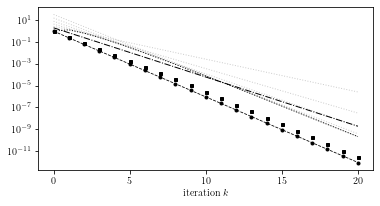

In [12]:
fig,axs = plt.subplots(1,1,figsize=(6,3))
axs = [axs]

axs[0].plot(error,color='k',ls='None',marker='o',ms=3,label='GMRES residual norm (independent $\mathbf{b}$)')
axs[0].plot(error_hard,color='k',ls='None',marker='s',ms=3,label='GMRES residual norm (dependent $\mathbf{b}$)')

axs[0].plot(((1-σ**2)/(1-σ**(2+2*np.arange(K))))**.5*(σ)**np.arange(K),color='k',ls='--',lw='.8',label='predicted rate for independent $\mathbf{b}$')

axs[0].plot(2*(np.sqrt(2)*σ)**np.arange(K),color='k',lw=1,ls='-.',label='field of values bound')

for η in [1+10**(-j/4) for j in range(5)]:
    axs[0].plot(η*em(η)*(σ*η)**np.arange(K),color='k',lw=1,ls=':',alpha=.2)

axs[0].plot(ps_bd,color='k',lw=1,ls=':',label=f'pseudospectrum bound')
axs[0].set_yscale('log')
#axs[0].legend()

axs[0].set_xticks([0,5,10,15,20])
axs[0].set_xlabel('iteration $k$')
plt.savefig('imgs/GMRES_example.pdf')